In [1]:
import numpy as np #Working with arrays
import pandas as pd #working with the dataset from yfinance API
import yfinance as yf
import matplotlib.pyplot as plt #need some visualisation

#Build and train the model with pytorch
import torch
import torch.nn as nn
import torch.optim as optim

#Scale and evaluate our metric
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
ticker = 'AAPL'
df = yf.download(ticker, '2020-01-01')

C:\Users\kaing\AppData\Local\Temp\ipykernel_19116\2867026071.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, '2020-01-01')
[*********************100%***********************]  1 of 1 completed


In [4]:
df

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.620834,72.681281,71.373211,71.627084,135480400
2020-01-03,71.914818,72.676447,71.689957,71.847118,146322800
2020-01-06,72.487846,72.526533,70.783248,71.034709,118387200
2020-01-07,72.146927,72.753808,71.926900,72.497514,108872000
2020-01-08,73.307526,73.609760,71.849548,71.849548,132079200
...,...,...,...,...,...
2025-07-08,210.009995,211.429993,208.449997,210.100006,42848900
2025-07-09,211.139999,211.330002,207.220001,209.529999,48749400


<Axes: xlabel='Date'>

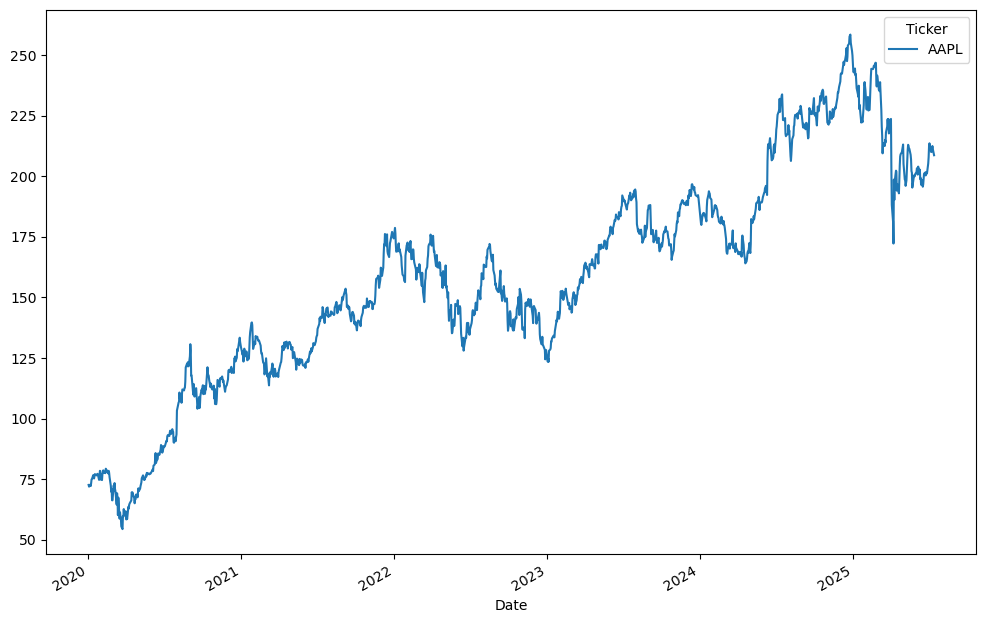

In [5]:
df.Close.plot(figsize=(12,8))

In [ ]:
'''
fit_transform computes the min and max of the 'Close' column
Then, each value is scaled using x' = (x -min) / (max -min)
The result is that all values in 'Close' will be between 0 and 1 (unless you pass a custom range with feature_range=(a, b)).


Previously we used standard scaler:
scaler = StandardScaler()
df['Close'] = scaler.fit_transform(df['Close'])
Resulting values are centered around 0
Distribution has mean = 0 and std = 1

Example:
[100, 110, 120, 130, 140]

STANDARD SCALER: [-1.41, -0.71, 0.0, 0.71, 1.41]  # mean 0, std 1
MINMAXSCALER: [0.0, 0.25, 0.5, 0.75, 1.0]  # scaled between 0 and 1
'''

scaler = MinMaxScaler()
df['Close'] = scaler.fit_transform(df[['Close']])

In [8]:
df.Close

Ticker,AAPL
Date,
2020-01-02,0.089415
2020-01-03,0.085954
2020-01-06,0.088763
2020-01-07,0.087092
2020-01-08,0.092781
...,...
2025-07-08,0.762831
2025-07-09,0.768370
2025-07-10,0.774595


In [ ]:
seq_length = 60 # n : How many days we want the LSTM model to look back to predict the next day
data = [] #Storing our input sequences


'''
This creates sliding windows of n consecutive days from the 'Close' prices.
For example:
i=0 → days 0 to 29 (predict day 29)
i=1 → days 1 to 30 (predict day 30)
So each item in data is a window of 30 days, where the first 29 are inputs and the 30th is the prediction target.
'''
for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length])

data = np.array(data)

#You use 80% of the data for training, the rest for testing.
#Better to split the data between training and test as we want our model to perform well under unseen data.
#If we do not split, the model might be too 'used' to the training data set ad will struggle in real world scenarios"
#In this case, we will do a 80:20 split but a 70:30 is also acceptable
train_size = int(0.8 * len(data))

#Convert everything to pytorch tensors
X_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.Tensor).to(device) #first 29 days of prices
y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor).to(device) #the day you want to predict
X_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)


In [ ]:
'''
PyTorch Neural Network -subclassing nn.Module
'''
class PredictionModel(nn.Module):


    '''
    __init__: 
    input_dim: Number of features per time step (1, since it's just "Close" price)
    hidden_dim: Size of the hidden state in the LSTM
    num_layers: Number of stacked LSTM layers
    output_dim: Output dimension (1, since we’re predicting one price value)
    '''
    def __init__ (self, input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel, self).__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim


        #Defines an LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        #A fully connected layer to project the LSTM's output (from last time step) to the final prediction.
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device) #initialises hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device) #initalises cell state

        #out contains all hidden states at each time step: shape (batch_size, seq_len, hidden_dim)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        out = self.fc(out[:, -1, :]) #Grabs the hidden state from the last time step for each sequence: out[:, -1, :].

        return out
    

In [ ]:
model = PredictionModel(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1).to(device) #module needs to be sent to GPU or the CPU

In [ ]:
criterion = nn.MSELoss() #MEAN SQUARED ERROR
optimiser = optim.Adam(model.parameters(), lr=0.01) #Uses the Adam optimizer with a learning rate of 0.01 to update the model weights during training.

In [ ]:
num_epochs = 200

'''
This section is the training loop for your LSTM-based time-series prediction model.
it runs for num_epochs epochs and gradually reduces prediction error using gradient descent.

On each epoch, the model:
    Makes predictions
    Calculates how wrong they are (loss)
    Updates weights to do better next time
'''
for i in range(num_epochs):

    #Make the prediction: These are predictions for the 30th day based on the previous 29.
    y_train_pred = model(X_train)

    #We see how wrong is this prediction: Compares predicted prices with actual prices using MSELoss (mean squared error).
    loss = criterion(y_train_pred, y_train) # Lower loss = better prediction.

    if i % 25 == 0:
        print(i,loss.item())

    '''
    #We back propogate the loss and tweak it to move in the correct direction

    optimiser.zero_grad()
    Clears any existing gradients from the previous step.

    loss.backward()
    Performs backpropagation: calculates how the model should change its weights to reduce error.

    optimiser.step()
    Updates the weights based on gradients, using the Adam optimizer.
    '''
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

0 0.37517115473747253
25 0.02204883098602295
50 0.011137774214148521
75 0.0012035727268084884
100 0.0006661758525297046
125 0.0005400762893259525
150 0.00048493428039364517
175 0.000448763370513916


In [ ]:
'''
THAT WAS THE TRAINED MODEL, NOW LETS SEE THE HOW THE MODEL PERFORMS ON UNSEEN DATA
'''

#Tells the model it's in evaluation/inference mode (not training)
model.eval()

#Feeds the test data (X_test, i.e., sequences of past 29 days) into the trained model.Outputs predictions for the 30th day prices (scaled).
y_test_pred = model(X_test) 


'''
Previously, we scaled all price datausing the MinMaxScaler before training to bring it within a range of [0,1]
Now we are reversing that so we can interpret the predictions in actual price values (e.g., dollars).

For example:
original_prices = [100, 120, 130, 110, 115, 140]
scaled_prices that go into the neural network: [0.00, 0.25, 0.375, 0.50, 0.75, 1.00]

Lets say after training, the model predicts this on the test set:
y_test_pred_scaled = [[0.25], [0.5], [0.75]] <----- these outputs are still scaled

So we need convert them back into dollars($) and plot them
'''
y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())


In [ ]:
'''
Calculate the RMSE on both the training data and test data sets
RMSE measures the average magnitude of the error between predicted and actual values:
Lower RMSE = better predictions
'''

rain_rmse = root_mean_squared_error(y_train[:,0], y_train_pred[:, 0])
test_rmse = root_mean_squared_error(y_test[:,0], y_test_pred[:, 0])

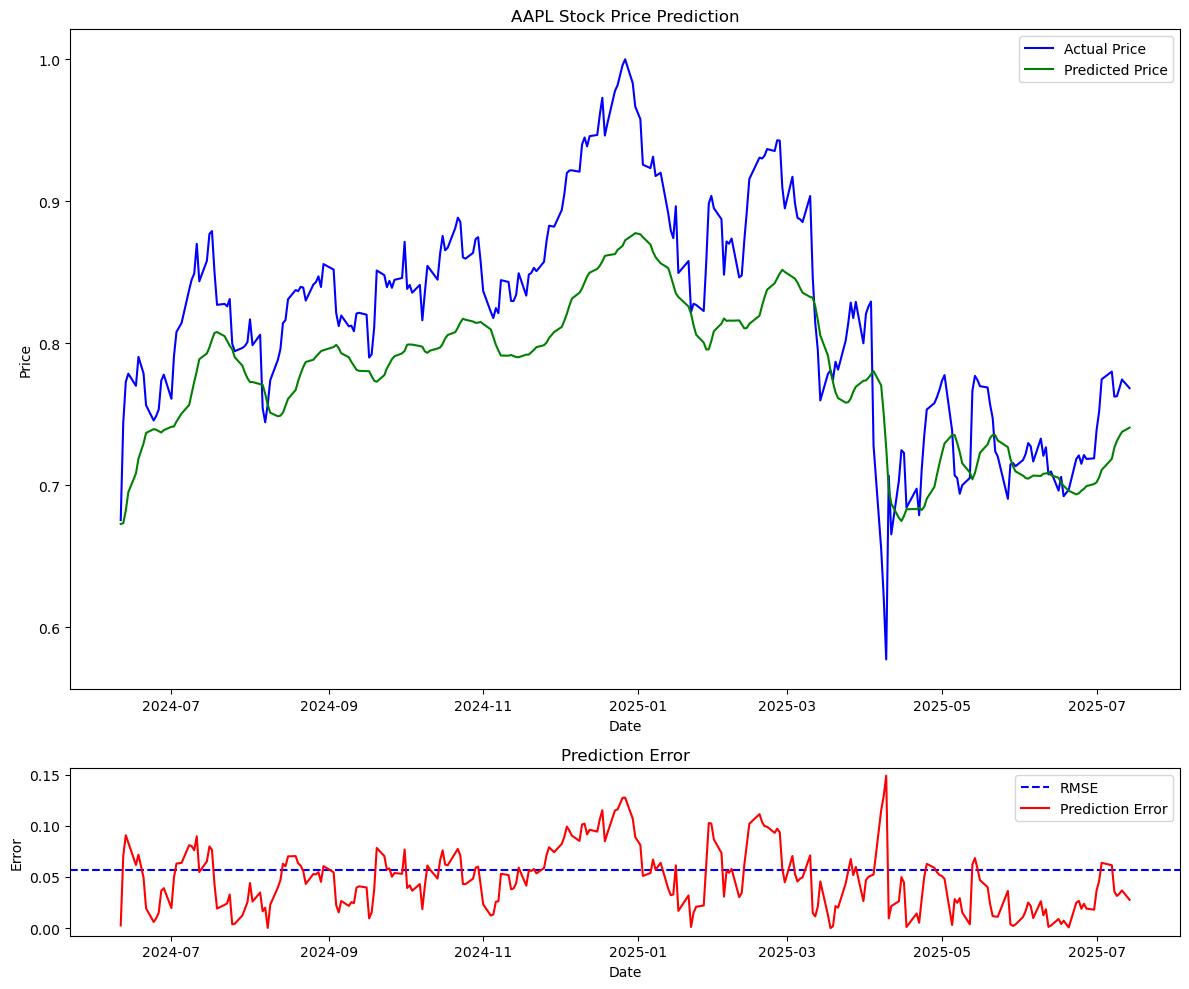

In [19]:
# Ensure predictions are numpy arrays
y_test_np = y_test.detach().cpu().numpy().squeeze() if hasattr(y_test, 'detach') else y_test.squeeze()
y_test_pred_np = y_test_pred.detach().cpu().numpy().squeeze() if hasattr(y_test_pred, 'detach') else y_test_pred.squeeze()

# Use numpy dates for x-axis
dates = df.iloc[-len(y_test_np):].index.to_numpy()

# Create figure and gridspec layout
fig = plt.figure(figsize=(12,10))
gs = fig.add_gridspec(4, 1)

# Plot actual vs predicted
ax1 = fig.add_subplot(gs[:3, 0])
ax1.plot(dates, y_test_np, color="blue", label='Actual Price')
ax1.plot(dates, y_test_pred_np, color="green", label='Predicted Price')
ax1.legend()
ax1.set_title(f"{ticker} Stock Price Prediction")
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')

# Plot error
ax2 = fig.add_subplot(gs[3, 0])
error = abs(y_test_np - y_test_pred_np)
ax2.axhline(test_rmse, color="blue", linestyle="--", label="RMSE")
ax2.plot(dates, error, color='red', label="Prediction Error")
ax2.legend()
ax2.set_title("Prediction Error")
ax2.set_xlabel("Date")
ax2.set_ylabel("Error")

plt.tight_layout()
plt.show()
